In [1]:
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division


Populating the interactive namespace from numpy and matplotlib


## Sample data

In [2]:
TEXT = file('big.txt').read()
len(TEXT)

6488666

In [4]:
def tokens(text):
    return re.findall('[a-z]+', text.lower()) 

In [6]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [9]:
def sample(bag, n=10):
    return " ".join(random.choice(bag) for _ in xrange(n))

In [11]:
sample(WORDS)

'and this militia leading third far which recognized people laws'

In [12]:
COUNTS = Counter(WORDS)

print COUNTS.most_common(10)

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [13]:
for w in tokens('the rare and neverbeforeseen words'):
    print COUNTS[w], w

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


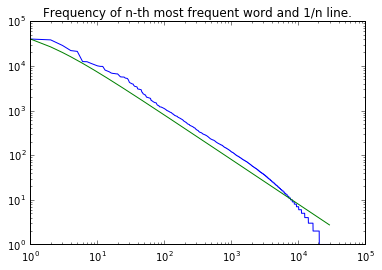

In [17]:
M = COUNTS["the"]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in xrange(1, len(COUNTS)+1)])

## Spellchecker using edit distances

In [29]:
def edits0(word):
    return {word}

def edits1(word):
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

def splits(word):
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def known(words):
    return {w for w in words if w in COUNTS}

In [34]:
def correct(word):
    candidates = (known(edits0(word)) or
                  known(edits1(word)) or
                  known(edits2(word)) or
                  {word})
    return max(candidates, key=COUNTS.get)

In [39]:
map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?'))

['spelling',
 'errors',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistakes',
 'everywhere']

In [42]:
def correct_text(text):
    return re.sub("[a-zA-Z]+", correct_match, text)

def correct_match(match):
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [43]:
correct_text('Speling Errurs IN somethink. Whutever; unusuel misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

## Probabilities of Word Sequences 

In [58]:
def prob_dist(counter):
    N = sum(counter.values())
    return lambda x:counter[x]/N

prob_word = prob_dist(COUNTS)

In [59]:
for w in tokens('"The" is most common word in English'):
    print prob_word(w), w

0.0724066643445 the
0.00884296810325 is
0.000821507574969 most
0.00025966153526 common
0.000269613719538 word
0.0199496057578 in
0.000190900989338 english


In [63]:
def prob_words(words):
    return product(prob_word(w) for w in words)

def product(nums):
    result = 1
    for x in nums:
        result *= x
    return result

In [64]:
prob_words("this is a car".split())

3.9403347791707763e-12

In [83]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [84]:
@memo
def segment(text):
    if not text:
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=prob_words)

In [85]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')
segment(decl)

['when',
 'in',
 'the',
 'course',
 'of',
 'human',
 'events',
 'it',
 'becomes',
 'necessary',
 'for',
 'one',
 'people',
 'to',
 'dissolve',
 'the',
 'political',
 'bands',
 'which',
 'have',
 'connected',
 'them',
 'with',
 'another',
 'and',
 'to',
 'assume',
 'among',
 'the',
 'powers',
 'of',
 'the',
 'earth',
 'the',
 'separate',
 'and',
 'equal',
 'station',
 'to',
 'which',
 'the',
 'laws',
 'of',
 'nature',
 'and',
 'of',
 'natures',
 'god',
 'entitle',
 'them']